In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
path = 'fast_face_cpu-20220419-171649'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.7.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,[]


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-19 17:16:49.074492,2.8,7134826496
1,2022-04-19 17:17:00.539490,58.9,7104516096
2,2022-04-19 17:17:12.744490,58.9,7099486208
3,2022-04-19 17:17:24.046495,57.9,7083720704
4,2022-04-19 17:17:35.545490,48.0,7102717952
...,...,...,...
278,2022-04-19 18:10:37.827445,58.5,8486354944
279,2022-04-19 18:10:50.185448,59.1,8454033408
280,2022-04-19 18:11:01.262946,58.4,8455045120
281,2022-04-19 18:11:13.284445,56.7,8506941440


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

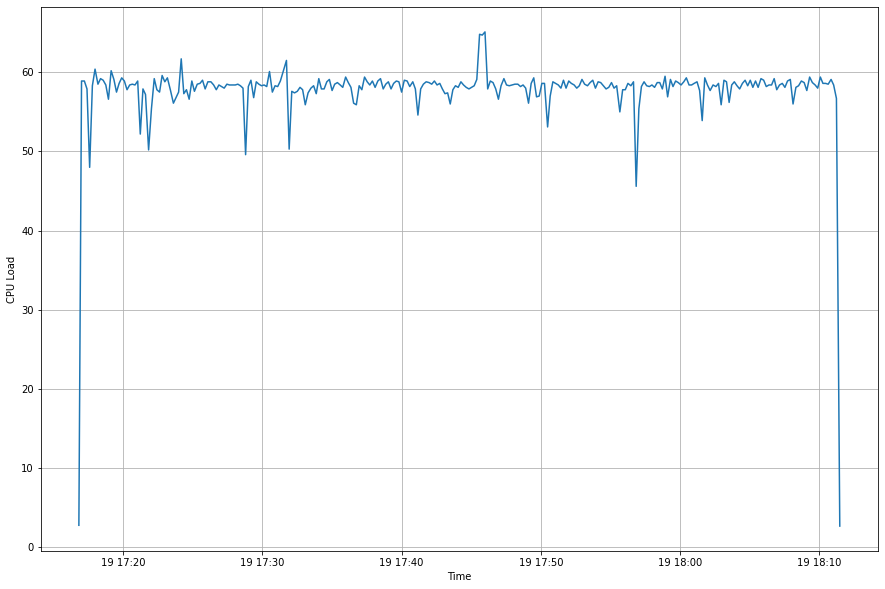

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

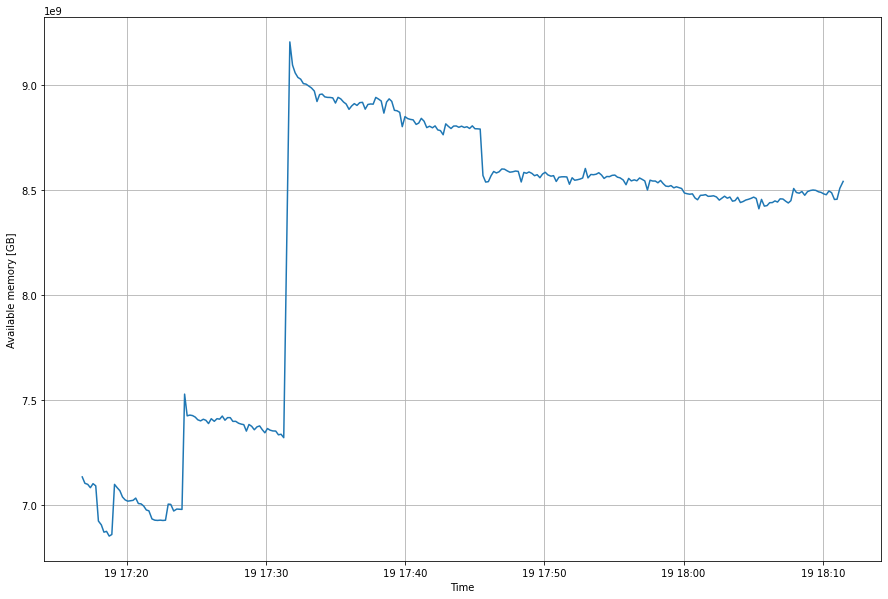

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

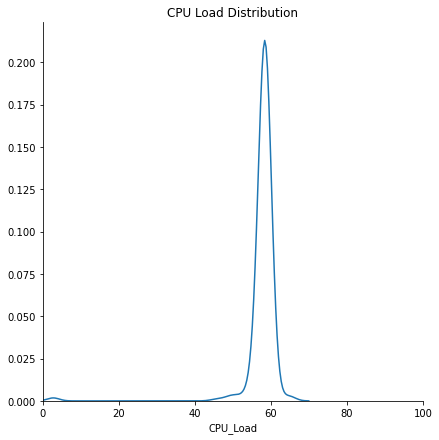

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

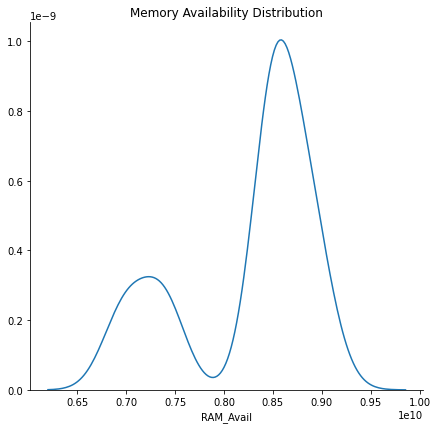

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-19 17:16:50.006491,859206900,1.0,1.000000,1.000000,"[0.8154292343387471, 0.7578603511637403, 0.858...",8,0,0,8,"[(778.0, 190.0, 857.0, 289.0), (603.0, 323.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-19 17:16:52.115490,2104435100,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-19 17:16:52.917991,797068300,1.0,1.000000,1.000000,"[0.8438381937911571, 0.7669295621430514]",2,0,0,2,"[(460.0, 41.0, 500.0, 93.0), (555.0, 113.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-19 17:16:53.871491,841314800,1.0,0.145161,0.253521,"[0.7743362831858407, 0.7935180345007841, 0.738...",9,0,53,62,"[(256.0, 496.0, 297.0, 546.0), (58.0, 494.0, 9...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-19 17:16:54.688990,800608600,1.0,1.000000,1.000000,"[0.9147646219686163, 0.8268525311812179, 0.902...",8,0,0,8,"[(272.0, 67.0, 317.0, 126.0), (789.0, 61.0, 83...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-19 18:11:13.284445,1698567500,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-19 18:11:15.019445,1729098100,0.0,0.000000,0.000000,[],0,0,2,2,[],"[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-19 18:11:15.904445,807369300,1.0,1.000000,1.000000,"[0.7758433079434167, 0.8760869565217392, 0.847...",27,0,0,27,"[(583.0, 321.0, 609.0, 353.0), (842.0, 348.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-19 18:11:16.715948,797355100,1.0,1.000000,1.000000,"[0.6940459110473458, 0.8743086978381096, 0.814...",7,0,0,7,"[(113.0, 110.0, 159.0, 165.0), (577.0, 67.0, 6...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,9.805525e+08,0.819177,0.688035,0.713624,5.033168,0.112213,7.275573,12.308741
std,5.301070e+08,0.361066,0.382665,0.360726,8.703122,0.370785,34.419591,39.822258
min,7.335243e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.836606e+08,1.000000,0.391693,0.528579,1.000000,0.000000,0.000000,1.000000
50%,8.066888e+08,1.000000,0.930952,0.888889,2.000000,0.000000,1.000000,3.000000
75%,8.458296e+08,1.000000,1.000000,1.000000,6.000000,0.000000,3.000000,9.000000
max,2.219751e+10,1.000000,1.000000,1.000000,120.000000,4.000000,649.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,1.000000,True,True,True
1,1.000000,True,True,True
2,1.000000,True,True,True
3,1.000000,True,True,True
4,1.000000,True,True,True
...,...,...,...,...
16594,0.800169,False,False,False
16595,0.800154,True,True,True
16596,0.800096,True,True,False
16597,0.800084,False,False,False


In [13]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [14]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,1.000000,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,1.000000,True,True,True,1.000000,0.000076,1.000000,0.000076,1.000000,0.000076
3,1.000000,True,True,True,1.000000,0.000101,1.000000,0.000101,1.000000,0.000101
4,1.000000,True,True,True,1.000000,0.000126,1.000000,0.000126,1.000000,0.000126
...,...,...,...,...,...,...,...,...,...,...
16594,0.800169,False,False,False,0.978246,0.408834,0.957698,0.400247,0.627418,0.262214
16595,0.800154,True,True,True,0.978248,0.408860,0.957701,0.400272,0.627440,0.262239
16596,0.800096,True,True,False,0.978249,0.408885,0.957703,0.400297,0.627403,0.262239
16597,0.800084,False,False,False,0.978190,0.408885,0.957645,0.400297,0.627365,0.262239


In [15]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

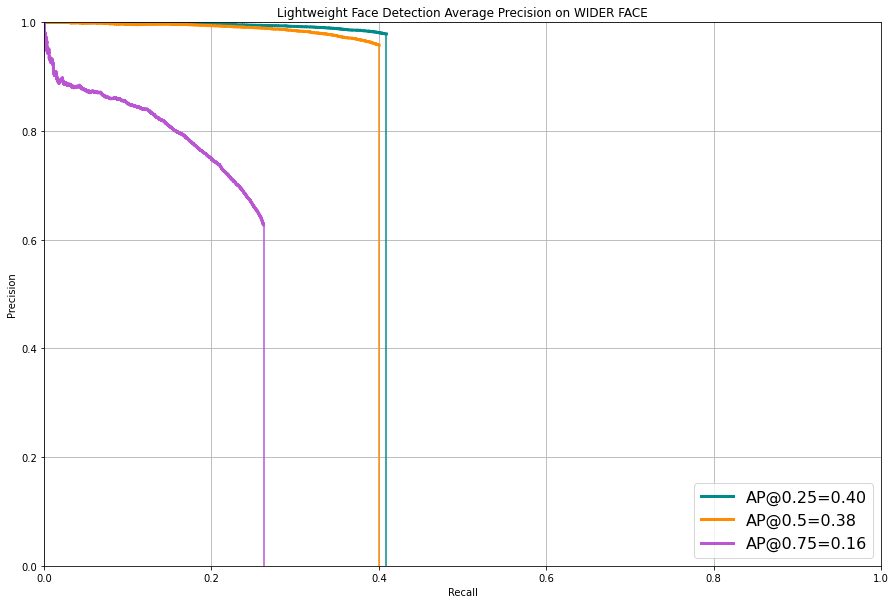

In [16]:
plot_pr(df_ap, 'Lightweight Face Detection Average Precision on WIDER FACE')